In [1]:
import os, sys
import ternary

# graphics and numpy imports
import matplotlib.pyplot as p
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.contour import ContourSet
from matplotlib.colors import LogNorm
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.path import Path
import matplotlib

import numpy as np
from scipy import stats

In [2]:
inelf = 'inel_flav_scan_delta_llh.txt'
ineldt = {'names': ('nue', 'numu', 'nutau', 'llh'),
          'formats': (float, float, float, float)}
data=np.loadtxt(inelf, dtype=ineldt, skiprows = 1)
print(len(data))
inel = data

1877


In [3]:
cnn_tau_scans = np.load('../stat_analysis/cnn_flav_comp_scan_new_sim_inelasticity.npy')

In [4]:
def frange(x, y, s):
    i = 0
    while True:
        v = x + s * i
        if v-1e-6 > y:
            break
        else:
            yield v
            i += 1

indexi, nuei, numui, llhi = [],[],[],[]

cnn_only = []
combined = []

for i in frange(0,1,1./60.):
    maski = np.abs(inel['nue']-i)<0.001
    indexi.append(i)
    for j in frange(0,1,1./60.):
        if (1-i-j)<-0.001:
            llhi.append(np.nan)
            cnn_only.append(np.nan)
            combined.append(np.nan)
        else:
            mask2i = np.abs(inel['numu']-j)<0.001
            llh2dselecti = inel['llh'][maski & mask2i]
            if len(llh2dselecti)>0:
                llhi.append(np.float(llh2dselecti[0]))
                cnn_only.append(cnn_tau_scans[:, 0][maski & mask2i])
                combined.append(cnn_tau_scans[:, 1][maski & mask2i])
            else:
                llhi.append(np.nan)
                cnn_only.append(np.nan)
                combined.append(np.nan)
            
llhi = np.array(llhi)
indexi = np.array(indexi)
cnn_only = np.array(cnn_only).reshape((len(indexi), len(indexi)))
combined = np.array(combined).reshape((len(indexi), len(indexi)))

In [5]:
def make_ax_invisible(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [6]:
chi2_dist = stats.chi2(2)

In [7]:
cnn_only.shape

(61, 61)

In [8]:
def ternaryplot(usePercentStyle=False):
    
    global plotname
    levels2 = [68, 95]
    cvs = [chi2_dist.ppf(l/100.0) for l in levels2]
    title = 'Flavor Ratio Sensitivity'
    print(cvs)
    
    # the plot
    fig = p.figure()
    fig.set_size_inches(12, 8)
    ax1=fig.add_subplot(111)
    make_ax_invisible(ax1)
    griddy = gridspec.GridSpec(2,2, height_ratios=[5, 30], width_ratios=[30, 1], hspace=0)
    ax = ternary.TernaryAxes.create(subplotspec=griddy[2])
    
    # fontsizes
    labelfontsize = 23
    legendfontsize = 19
    tickfontsize = 18
    annofontsize = 16

    labeli = 'Inelasticity (IceCube, PRD 2019)'
    markersize = 18
    markerwidth = 15
    markersize2=10

    xi = indexi 
    yi = indexi 
    tsi = -(min(llhi[llhi>0])-llhi)
    Zi = tsi.reshape((xi.size, yi.size))
    
    # contours
    CS4 = ax.ab.contour(xi, yi, Zi.T, levels=cvs, colors=['C0', 'C0'], linestyles=['-', '--'], linewidths=3, zorder=-6)
    # labels
    l0 = ax.plot([0], [0], color='C0')[0] 
    l1 = ax.plot([0], [0], color='C1')[0]
    l2 = ax.plot([0], [0], color='C3')[0]
    
    l3 = ax.ab.plot([1./3], [1./3], '*', color='C2', markersize=15)[0]
    
    # CNN alone contour
    CS = ax.ab.contour(xi, yi, (cnn_only - min(cnn_only[cnn_only>0])).T, 
                      levels=cvs, colors=['C3', 'C3'], linestyles=['-', '--'], 
                      linewidths=3, zorder=-6)
    
    # combined contour
    CS = ax.ab.contour(xi, yi, (combined - min(combined[combined>0])).T, 
                      levels=cvs, colors=['C1', 'C1'], linestyles=['-', '--'], 
                      linewidths=3, zorder=-6)
 
    fmt = {}
    for percent, level in zip(levels2, CS.levels):
        fmt[level] = f'{percent:.0f}%'
            
    ax.ab.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=24,
                 inline_spacing=15)
    
    
    # the legend
    lgd=ax.legend([l0, l1, l2, l3], [labeli, 'Combined', 'This analysis alone', '1 - 1 - 1'], handleheight=0.5,             
                   bbox_to_anchor=(-0.05, 1.13), scatterpoints=0, fontsize=legendfontsize)
    p.draw()

    # right label padding and positions
    labelpadabx, labelpadaby = 0.04, -0.06
    labelpadbcx, labelpadbcy = 0.04, -0.04
    labelpadcax, labelpadcay = 0.04, -0.02
    labelposabx, labelposaby = 0.5, 0.0
    labelposbcx, labelposbcy = 0.64, -0.1
    labelposcax, labelposcay = 0.34, -0.1
    majorticklabels = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']        
        
    # wrangle tick labels into the right place
    for txt in ax.ab.get_xticklabels():
        txt.set_rotation(60)
        txt.set_fontsize(tickfontsize)
        txt.set_horizontalalignment('center')
        txt.set_verticalalignment('center')
        x, y = txt.get_position()
        txt.set_position([x+labelpadabx, y+labelpadaby])

    for txt in ax.bc.get_xticklabels():
        txt.set_fontsize(tickfontsize)
        txt.set_horizontalalignment('left')
        txt.set_verticalalignment('center')
        x, y = txt.get_position()
        txt.set_position([x+labelpadbcx, y+labelpadbcy])

    for txt in ax.ca.get_xticklabels():
        txt.set_rotation(-60)
        txt.set_fontsize(tickfontsize)
        x, y = txt.get_position()
        txt.set_position([x+labelpadcax, y+labelpadcay])
        txt.set_horizontalalignment('right')
        txt.set_verticalalignment('bottom')

    # rotate ticks
    for label, rot in zip(('ab', 'bc', 'ca'), (30, -90, 150)):
        t = np.radians(rot)
        x = np.sin(t)
        y = np.cos(t)
        tickpath = Path(np.array([[0,0], [-x,-y]]), np.array([Path.MOVETO, Path.LINETO], dtype=np.uint8))
        for xt in getattr(ax, label).xaxis.get_major_ticks():
            l = xt.tick1line
            l.set_marker(tickpath)
            l.set_markersize(10)
            l.set_markeredgewidth(0.8)

        # remove the first and last ticks on each axis
        for xt in getattr(ax, label).xaxis.get_minor_ticks():
            l = xt.tick1line
            l.set_marker(tickpath)
            l.set_markersize(5)
            l.set_markeredgewidth(0.8)
                    
    # set labels
    ablabel = ax.ab.set_xlabel(r'Fraction of $\nu_{\mathrm{e}}$', labelpad=10, fontsize=labelfontsize)
    bclabel = ax.bc.set_xlabel(r'Fraction of $\nu_{\mu}$', labelpad=10, fontsize=labelfontsize)
    calabel = ax.ca.set_xlabel(r'Fraction of $\nu_{\tau}$', labelpad=10, fontsize=labelfontsize)
    ablabel.set_position((labelposabx, labelposaby))
    bclabel.set_position((labelposbcx, labelposbcy))
    calabel.set_position((labelposcax, labelposcay))
    ablabel.set_rotation(0)
    bclabel.set_rotation(-60)
    calabel.set_rotation(60)

    # the grid
    ax.grid(color='k', linestyle='-', linewidth=0.4, which='both')

    # save
    p.savefig(plotdir + "%s.pdf" % plotname, bbox_inches='tight')
    p.savefig(plotdir + "%s.png" % plotname, bbox_inches='tight', dpi=200)

[2.27886856637673, 5.991464547107979]


/home/atfienberg/packages/anac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


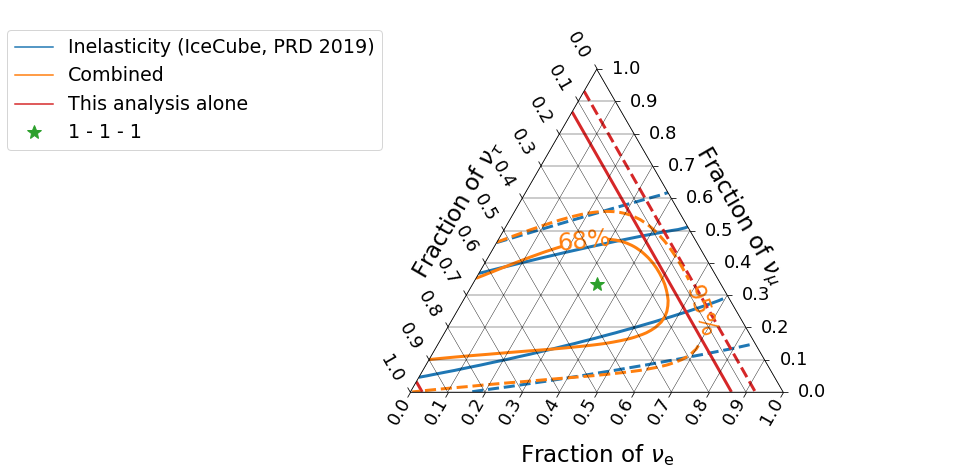

In [9]:
plotdir='./'
plotname='flavor_inelasticity'

ternaryplot()